In [12]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb
from scipy import interpolate
import random
from scipy.interpolate import KroghInterpolator
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from tqdm import tqdm
import xgboost as xgb

In [59]:
with open("/data/AIC21-R1/data/train_tracks.json") as f:
    train_tracks = json.load(f)

with open("/data/AIC21-R1/data/gt.json") as f:
    test_tracks = json.load(f)

cam1 = set()
cam2 = set()
for _, record in train_tracks.items():
    for frame in record['frames']:
        cam1.add(frame.split('/')[-3])
        
for _, record in test_tracks.items():
    for frame in record['frames']:
        cam2.add(frame.split('/')[-3])

non_exist = []
for cam in cam2:
    if cam not in cam1:
        non_exist.append(cam)

print(cam1)
num = 0
for _, record in test_tracks.items():
    for frame in record['frames']:
        cam = frame.split('/')[-3]
    if cam in non_exist:
        num += 1
print(num)
tracks = train_tracks

{'c028', 'c029', 'c008', 'c017', 'c035', 'c018', 'c027', 'c016', 'c021', 'c023', 'c019', 'c006', 'c020', 'c026', 'c010', 'c024', 'c033', 'c009', 'c022', 'c034', 'c036', 'c025', 'c007'}
128


In [266]:
print(non_exist)

['c012', 'c032', 'c001', 'c013', 'c004', 'c040', 'c014', 'c003', 'c030', 'c002', 'c005', 'c037', 'c038']


In [339]:
s = '-16.308808600574551 9.960439559719052 1596.500239711250970;3.744305520500265 4.967403633059964 291.408179914810717;-0.000097997314835 0.010979610816716 1.000000000000000'
s_list = s.split(';')
ans = []
for part in s_list:
    ans.append([float(r) for r in part.split(' ')])
print(ans)


[[-16.30880860057455, 9.960439559719052, 1596.500239711251], [3.744305520500265, 4.967403633059964, 291.4081799148107], [-9.7997314835e-05, 0.010979610816716, 1.0]]


In [340]:
homo_mat_dict = {
    'c012': [[-30.343617770195038,-2.607669134490869,1053.050392584949805], [-1.957073515449343,0.664480656377899,143.418849253758566],[-0.007422745663805,0.007549661516792,1.000000000000000]],
    'c032': [[-17.631992783980941,9.094122266923415,1574.128096340524962],[-7.183887816775120,4.392271221492352,703.661192085890320],[-0.000649644162254,0.010721699413577,1.000000000000000]],
    'c001': [[-33.391316152634239,-24.645266281592367,-815.911776622374418],[-3.187500816161974,0.400210599253526,171.861512099508360],[-0.016515000037136,0.003281226883010,1.000000000000000]],
    'c013': [[-26.787270474858779,31.978541490726386,4037.992401393782529],[16.601271158042085,4.080906475639374,-335.465404380827636],[0.008947516809707,0.015221962645235,1.000000000000000]],
    'c004': [[-39.291372888194246,25.978106765207865,4027.711065881301238], [-0.021847263534634,1.810459740085106,165.177331383179165],[0.005405520022462,0.013556326513098,1.000000000000000]],
    'c014': [[-1111.2753133295255, 1414.472944275724, 175481.75079241509], [-33.74731706619355, 18.815650381125934, 3140.132615370379], [0.192013987407833, 0.101020315361906, 1.0]],
    'c003': [[-42.47646124853751, 28.97728574032855, 4435.26769395962], [1.619110283049414, 0.012352961348296, -67.72984741141596], [0.008709056155396, 0.015104697996114, 1.0]],
    'c030': [[-17.516765527374684, -3.662477944555425, 412.28755461711785], [-1.316026668370003, 4.98977901109734, 508.4721404217246], [-0.011500096886277, 0.005637146073202, 1.0]],
    'c002': [[-31.161694819172737, -11.396862466146466, 291.2040204143391], [0.396463128717158, 0.225400890499393, 3.586890128992878], [-0.006903546986671, 0.007786571998405, 1.0]],
    'c005': [[-15.370624143703935, -16.910990968612595, -880.583055073008], [0.617067393635569, -0.927951621396068, -110.4305631942762], [-0.024780453550756, -0.00059298566588, 1.0]],
    'c037': [[-316.05544424679414, 151.26712535518962, 27151.697718117695], [-4.482203905797854, 0.744084877939007, 257.9875353090524], [0.014334579562796, 0.017742309307501, 1.0]],
    'c038': [[-26.01541660785874, -97.07308908178862, -7698.765471946092], [-31.338661408365912, -28.181916589941807, -1224.2093329332286], [-0.061954121281643, -0.018004353348481, 1.0]],
    'c040': [[-16.30880860057455, 9.960439559719052, 1596.500239711251], [3.744305520500265, 4.967403633059964, 291.4081799148107], [-9.7997314835e-05, 0.010979610816716, 1.0]],
}

In [351]:
homo_mat_dict = {
    'c012': [
        [-30.343617770195038,-2.607669134490869,0],
        [-1.957073515449343,0.664480656377899,0],
        [0,0,1.000000000000000]],
    'c032': [
        [-17.631992783980941,9.094122266923415,0],
        [-7.183887816775120,4.392271221492352,0],
        [0,0,1.000000000000000]],
    'c001': [
        [-33.391316152634239,-24.645266281592367,0],
        [-3.187500816161974,0.400210599253526,0],
        [0,0,1.000000000000000]],
    'c013': [
        [-26.787270474858779,31.978541490726386,0],
        [16.601271158042085,4.080906475639374,-0],
        [0,0,1.000000000000000]],
    'c004': [
        [-39.291372888194246,25.978106765207865,0],
        [-0.021847263534634,1.810459740085106,0],
        [0,0,1.000000000000000]],
    'c014': [
        [-1111.2753133295255, 1414.472944275724, 0], 
        [-33.74731706619355, 18.815650381125934,0],
        [0,0, 1.0]],
    'c003': [
        [-42.47646124853751, 28.97728574032855, 0],
        [1.619110283049414, 0.012352961348296, 0], 
        [0,0, 1.0]],
    'c030': [
        [-17.516765527374684, -3.662477944555425, 0], 
        [-1.316026668370003, 4.98977901109734, 0], 
        [0,0, 1.0]],
    'c002': [
        [-31.161694819172737, -11.396862466146466, 0],
        [0.396463128717158, 0.225400890499393, 0],
        [0,0, 1.0]],
    'c005': [
        [-15.370624143703935, -16.910990968612595, 0],
        [0.617067393635569, -0.927951621396068, 0], 
        [0,0, 1.0]],
    'c037': [
        [-316.05544424679414, 151.26712535518962,0],
        [-4.482203905797854, 0.744084877939007, 0], 
        [0,0, 1.0]],
    'c038': [
        [-26.01541660785874, -97.07308908178862, 0],
        [-31.338661408365912, -28.181916589941807, 0], 
        [0,0, 1.0]],
    'c040': [
        [-16.30880860057455, 9.960439559719052, 0],
        [3.744305520500265, 4.967403633059964, 0],
        [0,0, 1.0]],
}

In [218]:
homo_matrix = np.array([[-33.391316152634239, -24.645266281592367, -815.911776622374418], 
               [-3.187500816161974, 0.400210599253526, 171.861512099508360], 
               [0, 0, 1.000000000000000]])

In [219]:
homo_matrix.shape
np.linalg.inv(homo_matrix)

array([[-4.35388392e-03, -2.68115409e-01,  4.25263345e+01],
       [-3.46767641e-02,  3.63263529e-01, -9.07241995e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [223]:
homo_matrix = np.array([[-39.660220243283760, 15.592282221103229, 3099.834691537730578],
                        [-1.073038463974085, 0.181163893667474, 62.034492542754101],
                        [0, 0, 1.000000000000000]])

In [224]:
homo_matrix.shape
np.linalg.inv(homo_matrix)

array([[ 1.89777543e-02, -1.63336355e+00,  4.24969779e+01],
       [ 1.12405733e-01, -4.15459117e+00, -9.07112358e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [105]:
homo_matrix = np.array([
     [-31.161694819172737,-11.396862466146466,291.204020414339084], [0.396463128717158,0.225400890499393,3.586890128992878], [-0.006903546986671,0.007786571998405,1.000000000000000]
])

In [107]:
homo_matrix = np.array([
    [-21.997591847327296,-3.745927127290156,595.151212291002253],
    [0.048533439450522,-0.279593223283112,-27.417364958786596],
    [-0.009519266410793,0.006565856902287,1.000000000000000]
])

In [87]:
with open("/data/AIC21-R1/data/train_tracks.json") as f:
    tracks = json.load(f)

In [247]:
h = np.array([[-27.427113961042565,-39.189053665166234,-2389.953892327823723], 
              [2.476953702287311,2.548626326045717,125.966417265179615],
              [0.0,0.0, 1.000000000000000]])
h = np.linalg.inv(h)
print(h)

[[  0.09380984   1.44247069  42.49832264]
 [ -0.09117171  -1.00953721 -90.7284024 ]
 [  0.           0.           1.        ]]


77 149
['A black jeep turns right while other vehicles continue to move straight.', 'A black SUV turns right.', 'A black SUV is turning right.']
0 120
['A red truck turns left at an intersection.', 'A purple pickup truck making a left turn at the intersection.', 'A deep red pickup turns left at an intersection.']
594 729
stop
['A white SUV stops at an intersection.', 'A white SUV turns left according to the order of the traffic light.', 'White SUV stops at the intersection then turns left.']
579 727
['A mint wagon turns left at the intersection.', 'A gray wagon turns left following white SUV.', 'A silver van turns right at the intersection.']
598 728
['A blue SUV does a left turn.', 'A blue wagon turns left on the intersection.', 'A blue SUV turns left.']
204 337
['A white pickup truck tuns left at the turn signal.', 'White dodge pickup truck turns left at the intersection.', 'A white pickup turns left at the intersection.']
341 443
stop
['White sedan stops at the intersection then tak

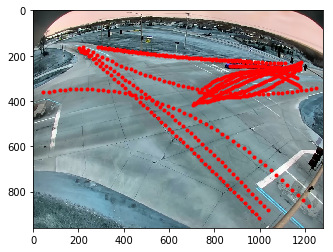

{'c005': 0}
19 189
['A small hatchback drives over a crosswalk.', 'A silver SUV quickly goes forward.', 'A gray wagon drives straight through an intersection.']
1 178
['A blue sedan drives down the street followed by a dark vehicle.', 'A blue hatchback goes straight on the street.', 'A blue sedan goes down the street followed by another black sedan.']
85 344
stop
['Cadillac car makes a left turn onto the main street.', 'A black sedan stops.', 'A black sedan turns left.']
6 198
['A black sedan goes down the straight after a blue sedan.', 'A black sedan keeping straight down the street followed by another black vehicle.', 'A mid-sided blue sedan goes straight through an intersection behind a blue vehicle.']
43 323
['A black pickup truck runs down the street.', 'A black pickup truck runs down the street and was followed by a white SUV that turned right at the previous intersection.', "A large Chevy pickup drives downhill on a two-lane road at a moderate speed. The vehicle's color is diffi

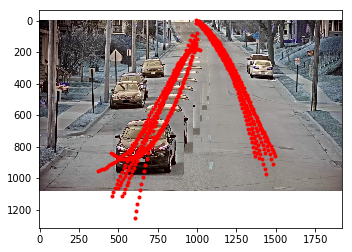

{'c005': 0, 'c014': 0}
18 149
['A red wagon keeps straight down the road.', 'A red van following by the pickup turns right.', 'A red pickup drives forward down the road.']
13 152
['A white van with courier logos runs down the street.', 'A FedEx van goes straight.', 'A white truck goes straight.']
8 141
['A white SUV runs down the street.', 'A gray SUV runs down the street and is followed by a blue sedan.', 'A white SUV runs down the street behind a black car.']
(3, 3)
[[-3.09625347e-03  6.59985822e+00 -3.08645449e+03]
 [ 8.34864548e-04 -2.59879406e+00  2.46098714e+03]
 [ 2.27620793e-03 -6.99975286e+00  5.85493884e+03]]


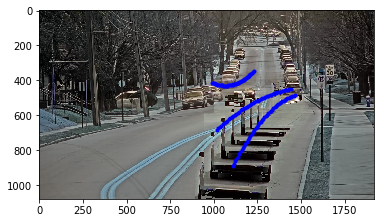

{'c005': 0, 'c014': 0, 'c029': 0}
0 58
['A blue pickup truck keeps straight at an intersection.', 'A blue pickup drives through the intersection.', 'A blue Pickup Truck running down the street.']
0 64
['A large dark gray pickup crosses an intersection.', 'A pickup leads others.', 'A grey pickup truck runs down the road alongside a truck.']
0 54
['A blue sedan drives through an intersection.', 'A blue sedan moves straight passing cargo truck on the intersection.', 'A blue sedan runs through an intersection.']
68 139
['A gray SUV goes straight in the road.', 'A silver car waits at the intersection.', 'Silver van going trough intersection.']
104 157
stop
['A black SUV going straight down the street passing an intersection.', 'A wagon stops at the traffic light and then goes across the intersection.', 'A large SUV drives straight through the intersection in the left lane.']
23 162
stop
['White pick up truck follow the car and stops at the intersection before proceeding.', 'White Pickup tru

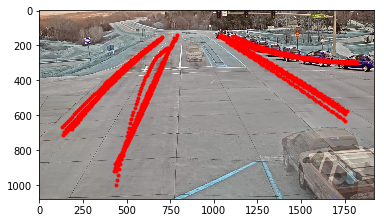

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0}
0 104
['A black SUV runs straight ahead at the street.', 'Black SUV keeps straight on an S-bend.', 'A black SUV turns left at the traffic lights.']
0 28
['A white pickup keeping straight after entering the street.', 'White pickup merges onto traffic from left lane.', 'A pickup truck turned right following a sedan.']
(2, 3)
[[-4.13748154e-04  1.15969001e+00 -4.85320769e+02]
 [ 8.27828447e-06 -3.40799778e-02  2.01387918e+02]]


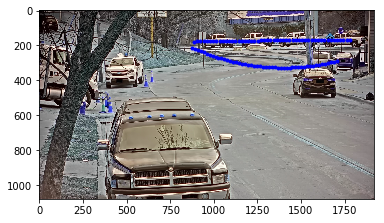

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0}
0 51
['A small dark red sedan turns left.', 'A brown sedan turns left.', 'A maroon sedan makes a left turn.']
(1, 3)
[[ 1.95841482e-04 -1.31670176e-01  4.15157525e+02]]


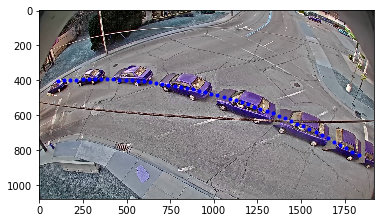

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0}
0 67
['A silver sedan turns right.', 'A silver color sedan car turn right.', 'A silver SUV turns right on an empty street.']
0 58
['A black sedan runs on the street.', 'Black car turns right at the intersection.', 'A blue sedan turns right.']
(2, 3)
[[ 2.14630557e-04 -5.64617187e-01  1.50691495e+03]
 [ 4.46990391e-04 -1.41468473e+00  1.80995212e+03]]


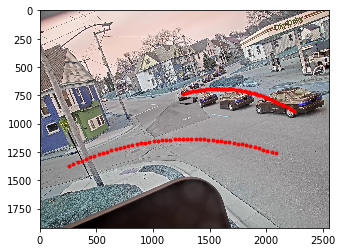

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0}
0 183
['A silver sedan breaks behind another car.', 'A gray sedan keeps straight down the road behind another white vehicle.', 'A white sedan runs down the street.']
0 218
['A black sedan runs on the street.', 'A black car is going straight.', 'A black sedan going straight down the street with cars parking on the side.']
0 113
['White pickup truck turns right.', 'A white pickup truck turns right.', 'A white pickup truck turns right towards the parking lot.']
0 82
['A white truck turns left.', 'A white pickup truck making a left turn.', 'A white pickup truck is going straight.']
(4, 3)
[[-1.80830488e-05  3.04060734e-01 -4.40706802e+00]
 [-2.37756729e-05  3.13780990e-01 -5.56882598e+00]
 [ 1.98201311e-04 -2.03888235e-01  2.40193703e+02]
 [ 1.31396489e-04 -8.89286870e-02  2.14628940e+02]]


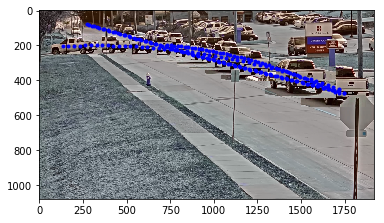

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0}
0 59
['Black pickup truck keeps straight and catches up with another black pickup truck.', 'A dark pick up truck drives straight in the right lane.', 'A black pickup truck keeps straight and get close to another black pickup truck.']
(1, 3)
[[-1.15765434e-04 -1.55037599e-02  1.54747746e+03]]


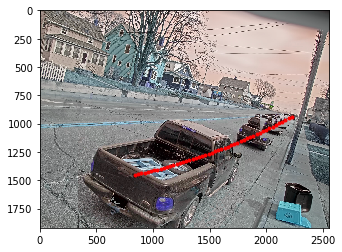

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0}
0 176
['A black sedan keeps straight.', 'Black sedan going straight on road.', 'Black sedan going straight on the road then turning left.']
0 154
['A green bus going down a curvy road.', 'A green bus driving straight the street.', 'Green bus turning left on road.']
(2, 3)
[[ 2.18495385e-03 -5.11881062e+00  3.21959669e+03]
 [ 8.65950755e-04 -1.99494975e+00  1.21996978e+03]]


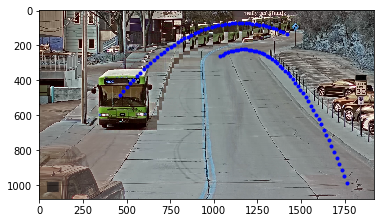

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0}
0 76
['A large black pickup turns right.', 'A black pickup truck making a right turn at the intersection.', 'A black pickup truck turns right at the intersection.']
455 612
['A large maroon car is driving through the intersection.', 'A reddish 4-door car drives through an intersection.', 'A sedan drives through the intersection.']
0 106
['Black chevy pick up truck drives straight.', 'A black pickup crosses a wide intersection.', 'A black pickup truck is changing lanes once crossing an intersection.']
0 94
['A red pickup crosses an intersection.', 'Red hatchback going straight.', 'A red pickup truck runs straight through the intersection.']
0 72
['A white pickup truck runs down the street behind a red pickup truck.', 'A white pick up truck goes straight through the intersection.', 'Silver chevy pickup truck with decals in the rear driving through the intersection.']
264 740
sto

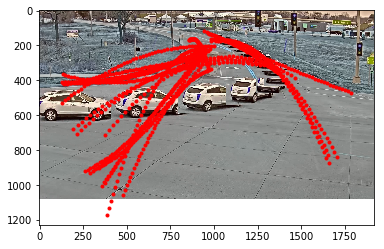

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0}
0 133
['A white sedan keeps straight with a black vehicle parking aside.', 'A white sedan turns left onto a residential street with the headlights on.', 'It is a white sedan.']
(1, 3)
[[ 1.63520371e-03 -2.23367800e+00  9.44183204e+02]]


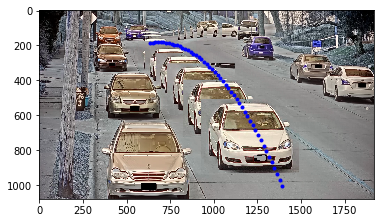

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0}
64 363
stop
['A black pickup waits at an intersection.', 'A pickup truck turns left onto the street before turning left at an intersection.', 'A truck turns left and then stops before a stop sign when it is going to enter the main road.']
(1, 3)
[[-1.56123800e-03  5.84909197e+00 -4.71594857e+03]]


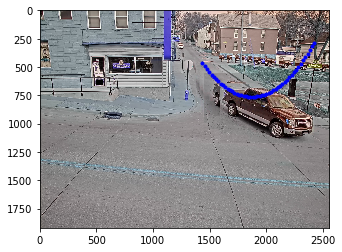

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0}
0 54
['A purple sedan keeps straight.', 'A blue sedan drives straight down a road.', 'A blue sedan runs down the street with vehicles parking vertically on the right side.']
0 69
['A gray sedan runs down the street and crosses an intersection straight.', 'A gray sedan drives straight in the right lane.', 'A grey coupe keeps straight on the road without any other vehicle around.']
39 144
stop
['A black sedan stops at an intersection.', 'The black car stops at the light to take a left behind the red car.', 'A gray sedan stops on the intersection and turns left.']
22 156
stop
['A red sedan makes a right turn as it is followed by a gray sedan.', 'Sedan (4 Door) goes in front of a gray car and stops at the intersection and then continues.', 'A maroon sedan stops at the intersection and then turns right followed by another grey vehicle.']
4 120
['A w

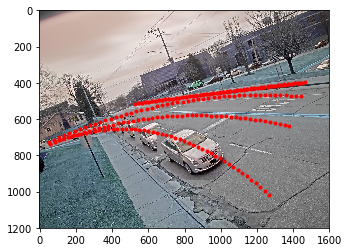

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0}
0 60
['A gray sedan going straight down the street with cars parking on the side.', 'A small sedan runs down the street passing parked cars.', 'A silver coupe driving straight down the road.']
(1, 3)
[[3.34828910e-05 2.39432505e-01 7.01172416e+02]]


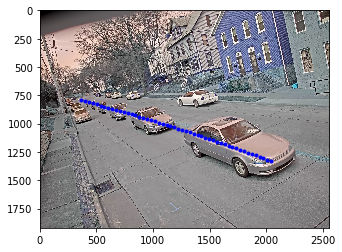

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0}
18 207
['A gray van runs down the street followed by a gray sedan.', 'A medium gray vehicle moving on behind another car.', 'A grey van keeps straight behind a black car.']
1 145
['A brown sedan runs down the street followed by another vehicle.', 'Convertible dark-colored car with a gray car behind it.', 'A black sedan keeps straight followed by another vehicle.']
24 205
['Silver small-sized sedan going straight.', 'A silver sedan runs down the street following several other cars.', 'A silver sedan runs down the street following a red coupe.']
0 120
['A gray sedan keeps straight followed by a silver vehicle.', 'A gray sedan crosses the intersection with all other cars parked.', 'A gray sedan going straight down the street with cars parking on the side.']
17 248
['A red minivan is being followed by a silver vehicle.', 'A re

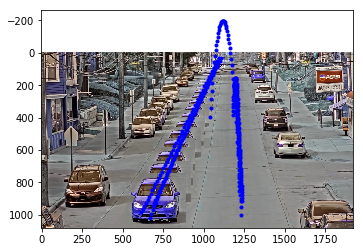

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0}
3 118
['White car keeps straight.', 'White Sedan runs down the street.', 'SUV car traveling on the road in straight.']
3 149
['A blue car is going straight.', 'A black Chevrolet runs down the street with all other cars parked.', 'A black sedan runs down the street.']
(2, 3)
[[-7.55527628e-03  6.07324364e+00 -6.87599570e+01]
 [ 4.13586113e-03 -9.74011297e+00  5.12285943e+03]]


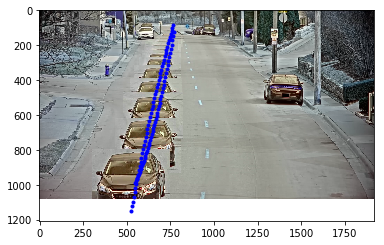

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0}
15 86
['A big green cargo truck drives down an intersection with many smaller cars running in different directions.', 'The large green flatbed 18 wheeler is going straight.', 'A green semi-truck drives through an intersection.']
0 52
['A red sedan switches lane to left and passes a cargo truck.', 'A red sedan keeps straight through an intersection.', 'A dark-red car is going straight.']
0 47
['A silver sedan keeps straight and overtakes a giant cargo truck.', 'A white Sedan going straight down the street passing an intersection.', 'A silver sedan drives through an intersection.']
0 39
['A blue wagon going straight down the street passing an intersection.', 'A gray SUV runs down the street.', 'A gray SUV drives across an intersection.']
0 47
['A red pickup goes straight at the intersection.', 'A red pi

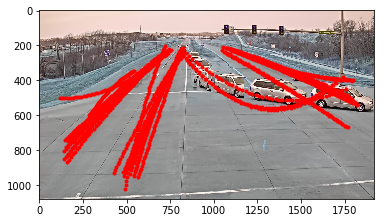

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0}
30 242
['A white pick up turning right.', 'Move straight and at cross continue to left. There is a sedan behind it.', 'A midsize white pickup truck goes straight (slight left).']
7 168
stop
['A gray Van stops at the intersections on a busy road.', 'A silver sedan slows down behind a white SUV under a stop sign and turns right.', 'A silver van pulls up to a stop sign before turning right.']
15 177
stop
['Grey car switches to the right lane and stops at the intersection.', 'A midsize gray car merges right and drives ahead.', 'A gray sedan merges left to begin a turn.']
0 117
['A black Sedan runs down the street straight.', 'A small black sedan turns left to merge in another road.', 'A black sedan turns left onto the street before continuing straight.']
1 149
['A silver car turns right.', 'A g

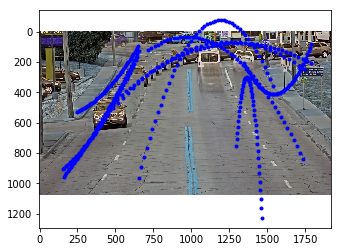

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0}
1878 1946
['A white post office car turn right.', 'A white USPS van making a left turn from the parking lot to the road.', 'A white pickup truck leaves the parking lot and turns left on the main street.']
(1, 3)
[[-2.97715685e-04  1.33404323e+00 -9.19524642e+02]]


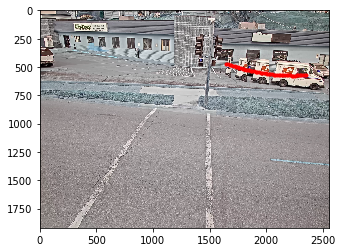

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0}
93 246
stop
['A dark SUV that is going straight the intersection followed by a large pickup truck.', 'Blue SUV stopped at the light and turning.', 'Black SUV going straight.']
0 97
stop
['A white van turns right.', 'A white van turns right at an intersection.', 'A white van stops then turn right onto right lane.']
19 156
stop
['A black SUV stops at the intersection and slowly turns right.', 'A black SUV stops at the intersection with a white sedan to the left of it.', 'A black SUV stops at the intersection followed by another black vehicle.']
90 216
stop
['A burgundy sedan stops at an intersection with another white car next to it.', 'A red sedan stops at the intersection with another white car.', 'A black small sedan stopped at the traffic signal and runs thru straigh

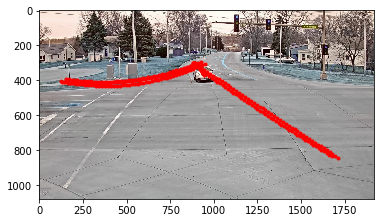

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0}
38 226
stop
['A white sedan runs down the street.', 'A white sedan is behind a pickup truck.', 'A white car is stopped behind a truck.']
11 381
['A white delivery van runs down the road.', 'A white van drives straight.', 'A white van going straight the road.']
0 176
['A white pickup driving.', 'A White SUV running down the street.', 'White van goes straight on road.']
0 106
['A black MPV runs down the street.', 'A black SPV runs down the street.', 'A black wagon runs down the street passing a white house on the right side.']
0 82
['A gray 4 Door sedan is driving straight in the right of two lanes.', 'A gray sedan runs down the street passing parking lot on the right side.', 'White Sedan runs down the street.']
0 100
['A brown SUV runs down the street.', 'A b

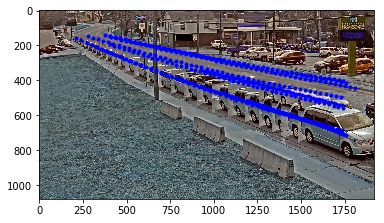

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0, 'c034': 0}
6 124
['A blue vehicle drives straight past parked cars.', 'A blue hatchback moving straight.', 'A small blue coup runs down the street.']
1 105
['Red sedan straight.', 'A red sedan goes straight followed by another car.', 'A red sedan keeps straight.']
2 100
['A red sedan drives down a street behind a red car.', 'A red Sedan when down the road.', 'A dark red sedan runs down the street with vehicles parking aside.']
(3, 3)
[[-7.74557125e-02  1.48876426e+02 -7.06141398e+04]
 [-7.56848424e-02  1.43403949e+02 -6.69439566e+04]
 [-7.14079737e-02  1.35507775e+02 -6.33809267e+04]]


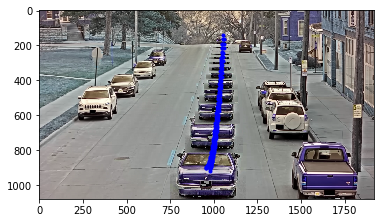

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0, 'c034': 0, 'c022': 0}
68 200
stop
['A black truck keeping straight on the road.', 'A blue pickup drives forward down the road.', 'A blue pickup truck runs down the street and stops at an intersection.']
10 141
['A grey cross over running down the street on a straight lane.', 'A soft grey car SUV switch lane to right and runs down the street followed by a black pickup truck.', 'A van is crossing a white dashed line. It is turning right.']
30 269
['A gray van runs down the street followed by a couple of sedans.', 'A white MPV turns right.', 'A black wagon drives straight for a bit.']
1 161
['A black pickup truck runs down the street.', 'A black pickup truck runs down the street followed by another white SUV.', 'A black truck runs the road to straight followed 

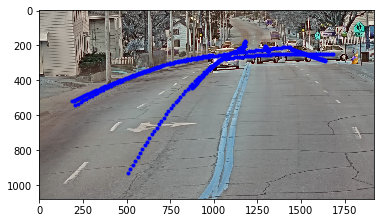

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0, 'c034': 0, 'c022': 0, 'c036': 0}
0 74
['A blue sedan runs down the street followed by gray sedan.', 'A blue car goes straight through an intersection.', 'A blue sedan runs down the street.']
6 62
stop
['A black Sedan going straight down the street passing an intersection.', 'A black sedan drives past a stoplight.', 'A black sedan keeps straight through a traffic light.']
0 77
['Car is followed by another car.', 'A gray sedan drives through an intersection.', 'A gray car is going straight.']
1 51
['A grey cross-over changes its lane and is ready to pass over another vehicle.', 'A gray hatchback merged to the right line.', 'A silver vehicle switches to the right lane next to a large truck.']
163 365
stop
['A red SUV stops at an intersection.', 'Maroon SUV is s

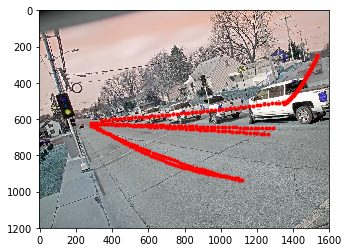

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0, 'c034': 0, 'c022': 0, 'c036': 0, 'c040': 0}
0 77
['A gray sedan keep straight.', 'A gray coupe goes straight down the street alone.', 'A midsize grey sedan runs down the street.']
(1, 3)
[[2.61288461e-06 3.09825558e-01 9.64223431e+02]]


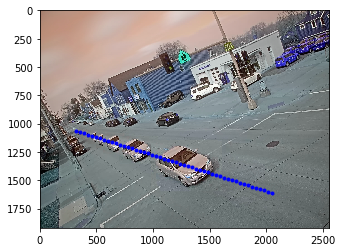

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0, 'c034': 0, 'c022': 0, 'c036': 0, 'c040': 0, 'c025': 0}
0 116
['A blue sedan runs down the street passing speed limit 30 sign.', 'A blue sedan going straight down the street.', 'A blue sedan keeps straight.']
0 51
['A black sedan overtaking a grey sedan.', 'A black sedan.', 'A black sedan slightly turns right along the street.']
(2, 3)
[[ 3.37903486e-04 -6.61460845e-01  8.88466531e+02]
 [-3.36001346e-04  4.40414132e-01  4.42004115e+02]]


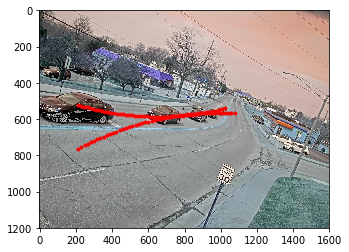

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0, 'c034': 0, 'c022': 0, 'c036': 0, 'c040': 0, 'c025': 0, 'c032': 0}
34 95
stop
['A white truck continues down the street followed by a black truck.', 'A white pickup truck turns right in the intersection.', 'A light grey Pickup briefly stops at a crosswalk before continuing.']
44 119
stop
['A black pickup stops at the intersection.', 'A black Pick up truck is reaching a stop sign.', 'A black pickup truck runs down the street behind another cargo pickup truck.']
25 99
['A black SUV runs down the street.', 'A black SUV keeps straight slowly following a white vehicle.', 'A black pickup runs straight up the street.']
(3, 3)
[[ 1.31120528e-04 -2.08969432e-01  2.63647818e+02]
 [ 2.08013426e-04 -4.20425718e-01  4.14292475e+02]
 [ 1.03033587e-04 -1.31312547e-01  2.205

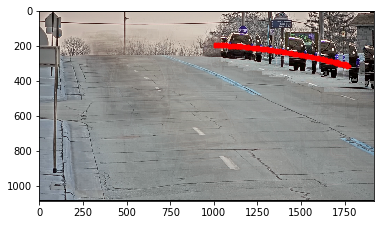

{'c005': 0, 'c014': 0, 'c029': 0, 'c003': 0, 'c017': 0, 'c035': 0, 'c013': 0, 'c027': 0, 'c038': 0, 'c016': 0, 'c002': 0, 'c021': 0, 'c019': 0, 'c030': 0, 'c020': 0, 'c026': 0, 'c010': 0, 'c004': 0, 'c033': 0, 'c012': 0, 'c001': 0, 'c034': 0, 'c022': 0, 'c036': 0, 'c040': 0, 'c025': 0, 'c032': 0, 'c037': 0}


In [100]:
import math 

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

def get_direction(texts):
    direction = 0
    num_left = 0
    num_right = 0
    for text in texts:
        if 'turn' in text:
            if 'left' in text:
                num_left += 1
            if 'right' in text:
                num_right += 1

    if num_left > num_right:
        direction = 1
    if num_left < num_right:
        direction = 2
    return direction

# tgt_camera = 'c017'
train_data = []
labels = []

intersection_dict = {}

stop_dict = dict()

for tgt_camera in cam2:
# for _ in range(1):
    
    z_params = []
    is_intersection = 0
    for uuid, record in test_tracks.items():

    #     print(record['frames'][0])
        camera = record['frames'][0].split('/')[-3]

        if camera != tgt_camera:
            continue
        
        image = cv2.imread('/data/AIC21-R1/data/motion_map/%s.jpg' % uuid)
        texts = record['nl']
#         print(texts)
        direction = get_direction(texts)
        
        path = []
        for box in record['boxes']:
            x = box[0] + box[2] // 2
            y = box[1] + box[3] // 2
            path.append(np.array([x, y, 1]))
    #     print(path)

        plt.imshow(image)
    #     plt.show()

#         mat_inv = np.linalg.inv(homo_matrix)

        gps_path = path
    #     for p in path:
    #         gps_path.append(np.matmul(homo_matrix, p))

    #     print(gps_path)
        n = len(gps_path)

        x = [p[0] for p in gps_path]
        y = [p[1] for p in gps_path]

    #     coefs = np.polyfit(x, y, 3)
    #     print(coefs)
    #     def curve_func(x, coefs):
    #         y = 0
    #         for idx, coef in enumerate(coefs):
    #             y += coef * x ** idx
    #         return y

    #     x, y = bezier_curve(gps_path, nTimes=2000)

    #     min_x = min(x)
    #     max_x = max(x)

    #     x = np.linspace(min_x, max_x, 50)
    #     y = np.array([curve_func(v, coefs) for v in x])

    #     x = sorted(x)
    #     y = sorted(y)
        x = [v + random.random() * 0.001 for v in x]
        y = [v + random.random() * 0.001 for v in y]
#         h = homo_mat_dict[camera]
#         h_inv = np.linalg.inv(h)
#         path = np.array([(i,j,1) for i, j in zip(x, y)])
#         newpath = np.matmul(h_inv, path.T)
#         path = newpath.T
        path = [(x, y) for x,y,_ in path]
        moves = [0] * len(path)
        for i in range(len(path)-1):
            moves[i] = ((path[i+1][0] - path[i][0])**2 + (path[i+1][1] - path[i][1]) ** 2)**(1/2)
        num_stops = 0
        pre = 0
#         print(camera)
        if camera not in intersection_dict:
            intersection_dict[camera] = 0
        
        num_zeros = 0
        
#         for v in moves:
#             num_zeros = max(num_zeros, num_stops)
#             if v < 1e-6:
#                 pre = 0
#                 num_stops += 1
#             if v > 1e-6:
#                 pre = v
#                 num_stops = 0
#         if num_zeros > 30:
#             stop_dict[uuid] = [0,1]
#         else:
#             stop_dict[uuid] = [1,0]

        for v in moves:
            num_zeros = max(num_zeros, num_stops)
            if v < 1e-5:
                num_stops += 1

        if num_zeros > 20:
            stop_dict[uuid] = [0,1]
        else:
            stop_dict[uuid] = [1,0]

        print(num_zeros, len(moves))
        for text in texts:
            if 'stop' in text:
                print('stop')
                break
        
        print(texts)
#         for v in moves:
#             if num_stops >= 15:
#                 intersection_dict[camera] = 1
#             if v < 1e-5:
#                 pre = 0
#                 num_stops += 1
#             if v > 1e-5:
#                 pre = v
#                 num_stops = 0
            
        x = [p[0] for p in path]
        y = [p[1] for p in path]
        
#         print(path)
        
        x = [v + random.random() * 0.001 for v in x]
        y = [v + random.random() * 0.001 for v in y]
    #     print(path)

    #     ids = np.linspace(0, len(path)-1, 100)
    #     path = [path[int(idx)] for idx in ids]

    #     path = np.array(path)
    #     print(path.shape)
#         distance = np.cumsum( np.sqrt(np.sum( np.diff(path, axis=0)**2, axis=1 )) )
#         distance = np.insert(distance, 0, 0)/distance[-1]
        
#         z = np.polyfit(distance, np.array([x, y]).T, deg=2)
#         z_params.append(z)

       
        z = np.polyfit(x, y, deg=2)
        train_data.append(z)
        labels.append(direction)
        z_params.append(z)

    #     print(z.shape)
    #     def poly2d(coefs, ts):
    #         x = []
    #         y = []
    #         p1 = np.poly1d(coefs[:,0])
    #         p2 = np.poly1d(coefs[:,1])
    #         for t in ts:
    #             x.append(p1(t))
    #             y.append(p2(t))
    #         return x, y

        alpha = np.linspace(0, 1, 50)
        x = np.linspace(min(x), max(x), 50)
        y = np.poly1d(z)(x)
#         x, y = poly2d(z, alpha)


    #     print(texts)
    
        if camera in non_exist:
            color = 'r.'
        else:
            color = 'b.'
        plt.plot(x, y, color)

    
    z_params = np.array(z_params)
#     n, w, h = z_params.shape
#     X = z_params.reshape((n, w*h))
#     print(z_params.shape)
#     x_z_params = z_params[:,:,0]
#     y_z_params = z_params[:,:,1]
#     print(x_z_params)
    
    print(z_params.shape)
    print(z_params)
    n = len(z_params)
#     if n != 1:
#         X = z_params
#         clustering = DBSCAN(eps=300, min_samples=1).fit(X)
#         print(clustering.labels_)
#         center = np.mean(z_params, axis=0)
#         print(center)
#         diff = 0
#         for k1, k2 in z_params:
#             diff += ((k1-center[0])**22 + (k2-center[1])**2)
#         diff /= len(center)
#         print(is_intersection)
#         print(diff)
    plt.show()
    print(intersection_dict)
#     print(intersection_dict[camera])
#     plt.imshow(image)
#     plt.show()


In [99]:
with open('time_aug.json', 'w') as fb:
    json.dump(stop_dict, fb)

In [49]:
X = np.array(train_data)
y = np.array(labels)

clf = SVC()
clf.fit(X, y)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=10, n_estimators=5)
model.fit(X, y)

test_data = []
test_labels = []
for uuid, record in test_tracks.items():
    texts = record['nl']
    direction = get_direction(texts)
    path = []
    for box in record['boxes']:
        x = box[0] + box[2] // 2
        y = box[1] + box[3] // 2
        path.append(np.array([x, y]))
    x = [p[0] for p in path]
    y = [p[1] for p in path]
    x = [v + random.random() * 0.001 for v in x]
    y = [v + random.random() * 0.001 for v in y]
    z = np.polyfit(x, y, deg=3)
    test_data.append(z)
    test_labels.append(direction)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)

(184, 4) (184,)


In [52]:
preds = model.predict(test_data)
summary = {}
loc = {}
for idx, (_, track) in enumerate(test_tracks.items()):
    camera = track['frames'][0].split('/')[-3]
    texts = track['nl']
    if camera not in summary:
        summary[camera] = [test_labels[idx]]
        loc[camera] = 0
    else:
        summary[camera].append(test_labels[idx])
    for text in texts:
        if 'intersection' in text:
            loc[camera] = 1
        
for key in summary:
    print(summary[key], loc[key])
# print(preds)
# print(test_labels)
# print(sum(test_labels == preds)/len(test_labels))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1] 1
[2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0] 1
[0, 2, 2, 0, 2, 0] 1
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1] 1
[0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0] 0
[1] 0
[2, 2] 1
[1, 1] 0
[2, 2, 1, 1, 2, 1, 1, 2, 1] 1
[0, 0, 0, 0, 0, 0, 0] 1
[1, 2] 0
[0] 0
[1] 0
[1] 1
[0, 0, 0] 0
[0] 0
[0, 0, 2, 1] 0
[0, 0, 0, 0, 0, 0, 2, 0, 0, 0] 1
[2, 0, 0] 0
[0, 2] 0
[0, 0, 1, 2, 2] 1
[0, 2, 2, 0, 1, 0, 0, 0, 1] 1
[2, 0, 0] 1
[1] 0
[0, 0, 0, 0, 0, 0] 1
[0] 0


In [31]:
dir_dict = {}
with open("/data/AIC21-R1/data/test_queries.json") as f:
    test_queries = json.load(f)
for idx, key in enumerate(test_tracks):
    vec = preds[idx]
#     if pred == 0:
#         vec = [1,0,0]
#     if pred == 1:
#         vec = [0,1,0]
#     if pred == 2:
#         vec = [0,0,1]
    dir_dict[key] = vec.tolist()
with open('dir.json', 'w') as fb:
    json.dump(dir_dict, fb)